In [3]:

import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight #для взвешивания классов
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,make_scorer,classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk
import spacy
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from collections import Counter
import seaborn as sns
import re

In [4]:
#завантаження дата сета зі спам і не спам повідомленнями!
data=pd.read_csv('extended_mail_data.csv')

In [5]:
#дивимося розмір
data.shape

(8358, 2)

In [6]:
#дивимося колонки
data.columns

Index(['Category', 'Message'], dtype='object')

In [7]:
#виведемо перші 5 рядів
data.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


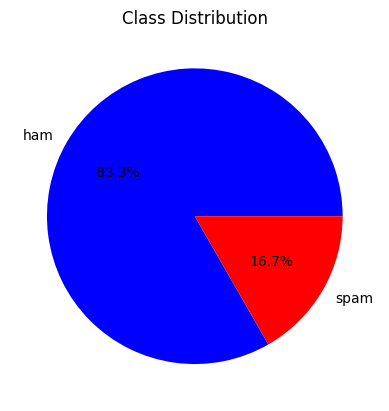

In [8]:
#подивимось на співвідношення класів

class_counts = data['Category'].value_counts()
class_counts.plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'red'], labels=class_counts.index)
plt.title('Class Distribution')
plt.ylabel('') 
plt.show()

In [9]:
#завантажимо стоп слова для видалення їх з тексту
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Intel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Intel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# зробимо лемантизацію тексту
nlp = spacy.load("en_core_web_sm")

In [11]:
#функції обробки тексту

def lemmatize_message(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])


def remove_punctuaction(text):
    # Створюємо таблицю для перекладу, яка видаляє всі розділові знаки, крім знака оклику
    table = str.maketrans('', '', string.punctuation.replace('!', ''))
    return text.translate(table)

def remove_stop_words(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def clean_text(text):
    text = re.sub(r'\d+', '', text)  #Видалення цифр
    return text

# Об'єднана функція яка послідовно застосовує всі функції
def preprocess_text(text):
    if pd.isna(text):  # Перевірка на відсутність значення
        return '' 
    text = str(text)  # Перетворення на рядок
    text = clean_text(text)  # Видалення цифр
    text = remove_punctuaction(text)  # Видалення пунктуації
    text = remove_stop_words(text) # Видалення стоп-слова
    text = lemmatize_message(text) # лимантизація
    return text

In [12]:
#застосовуємо функції для обробки тексту
data.loc[:, 'clean_data'] = data['Message'].apply(preprocess_text)
data.head()

,Category,Message,clean_data
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win FA Cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor U c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",Nah do not think go usf live around though


In [13]:
# видалимо не потрібні колонки
drop_columns=['Message']
data=data.drop(columns=drop_columns)
data.head()

,Category,clean_data
0,ham,go jurong point crazy Available bugis n great ...
1,ham,ok lar Joking wif u oni
2,spam,free entry wkly comp win FA Cup final tkts st ...
3,ham,u dun say early hor U c already say
4,ham,Nah do not think go usf live around though


In [14]:
#Проаналізуємо графік найчастіших слів у спам повідомленнях
spam_corpus = [] 
for words in data[data['Category']=='spam']['clean_data'].tolist():
    for word in words.split():
        if len(word)>=2:
            spam_corpus.append(word.lower())

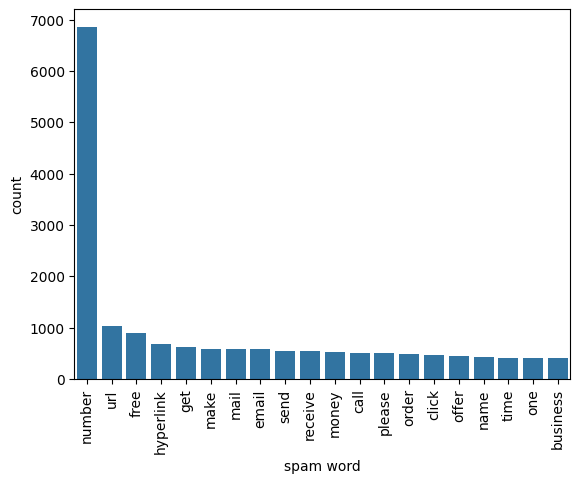

In [15]:
most_common_words = pd.DataFrame(Counter(spam_corpus).most_common(20), columns=['spam word', 'count'])
sns.barplot(x='spam word', y='count', data=most_common_words)
plt.xticks(rotation='vertical')
plt.show()

In [16]:
ham_corpus = [] 
for msg in data[data['Category'] == 'ham']['clean_data'].tolist():
    for word in msg.split():
        if len(word)>=2:
            ham_corpus.append(word.lower())

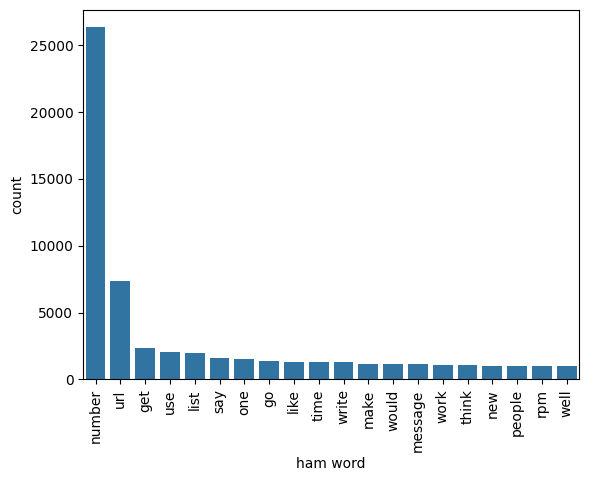

In [17]:
# подивимося на найчастіші слова в не спам повідомлення
most_common_words_ham = pd.DataFrame(Counter(ham_corpus).most_common(20), columns=['ham word', 'count'])
sns.barplot(x='ham word', y='count', data=most_common_words_ham)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
most_common_words = words_counts(data)
data = create_features(most_common_words, data)
data.head(1)

In [18]:
# Створимо ще одну ознаку з кількістю найпоширеніших слів у спам повідомленнях
def words_counts(data):
    spam_messages=[]
    for words in data[data['Category']=='spam']['clean_data'].tolist():
        for word in words.split():
            if len(word)>=2:
                spam_messages.append(word.lower())
    words_count=Counter(spam_messages)
    return words_count.most_common(20)


def create_features(words_count,data):
    words=[word for word,_ in words_count]
    for word in words:
        data[word] = data['clean_data'].apply(lambda x: x.lower().split().count(word)) 
        data['message_length'] = data['clean_data'].apply(len) 
        data['exclamation_count'] = data['clean_data'].apply(lambda x: x.count('!'))
        # Количество слов в сообщении
        data['word_count'] = data['clean_data'].apply(lambda x: len(x.split()))
        # Средняя длина слова
        data['avg_word_length'] = data['clean_data'].apply(lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0)
    return data

In [19]:
most_common_words = words_counts(data)
data = create_features(most_common_words, data)
data.head(1)

,Category,clean_data,number,message_length,exclamation_count,word_count,avg_word_length,url,free,hyperlink,...,money,call,please,order,click,offer,name,time,one,business
0,ham,go jurong point crazy Available bugis n great ...,0,82,0,16,4.1875,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
data.columns

Index(['Category', 'clean_data', 'number', 'message_length',
       'exclamation_count', 'word_count', 'avg_word_length', 'url', 'free',
       'hyperlink', 'get', 'make', 'mail', 'email', 'send', 'receive', 'money',
       'call', 'please', 'order', 'click', 'offer', 'name', 'time', 'one',
       'business'],
      dtype='object')

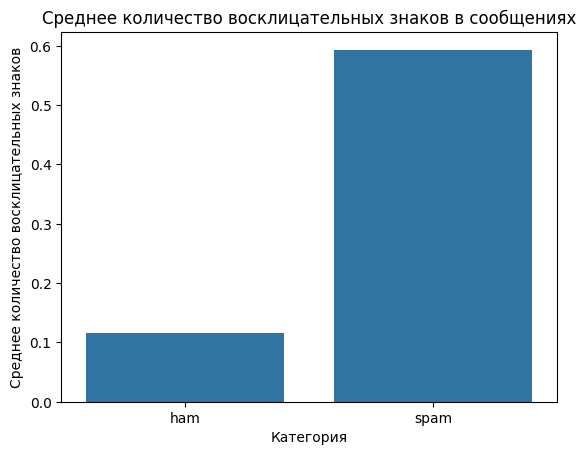

In [35]:
data_grouped = data.groupby('Category')['exclamation_count'].mean().reset_index()

# Візуалізація
sns.barplot(x='Category', y='exclamation_count', data=data_grouped)
plt.title('Среднее количество восклицательных знаков в сообщениях')
plt.xlabel('Категория')
plt.ylabel('Среднее количество восклицательных знаков')
plt.show()

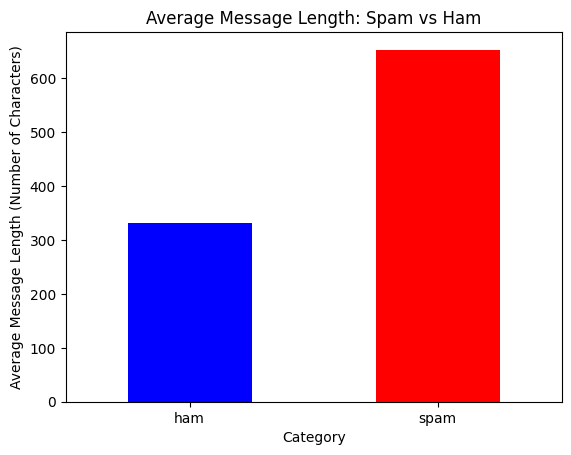

In [21]:
#поглянемо на середню довжину спам і не спам повідомлень
mean_lengths = data.groupby('Category')['message_length'].mean() 
mean_lengths.plot(kind='bar', color=['blue', 'red'])
plt.title('Average Message Length: Spam vs Ham')
plt.xlabel('Category')
plt.ylabel('Average Message Length (Number of Characters)')
plt.xticks(rotation=0)
plt.show()

In [22]:
# Перетворимо категоріальну ознаку 'Category' для spam 1 для спам 0
df = pd.DataFrame(data)

# Перетворення категоріальної ознаки 'Category'
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category']) 
df.head(5)

,Category,clean_data,number,message_length,exclamation_count,word_count,avg_word_length,url,free,hyperlink,...,money,call,please,order,click,offer,name,time,one,business
0,0,go jurong point crazy Available bugis n great ...,0,82,0,16,4.187500,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,ok lar Joking wif u oni,0,23,0,6,3.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,free entry wkly comp win FA Cup final tkts st ...,0,106,0,20,4.350000,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,u dun say early hor U c already say,0,35,0,9,3.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,Nah do not think go usf live around though,0,42,0,9,3.777778,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#Векторизуємо текст за допомогою TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english', 
    max_features=3000,
)


tfidf_matrix = tfidf.fit_transform(df['clean_data'])

# Перетворимо матрицю в DataFrame для зручності
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# З'єднуємо ознаки
X = pd.concat([df.drop(columns=['Category', 'clean_data']), tfidf_df], axis=1)
y = df['Category']  
print(len(X),len(y))

8358 8358


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
#перемішаємо дані перед навчанням
from sklearn.utils import shuffle


X_shuffled, y_shuffled = shuffle(X, y, random_state=42)

In [28]:
# Ініціалізуємо класифікатор
model = RandomForestClassifier(n_estimators=150,max_depth=None,min_samples_split=2, random_state=42,)

# Навчання моделі
model.fit(X_shuffled,y_shuffled)

# Прогнозування на тестових даних
y_pred = model.predict(X_test)



In [29]:
# виведемо звіт про якість моделі з основними метриками
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1373
           1       1.00      1.00      1.00       299

    accuracy                           1.00      1672
   macro avg       1.00      1.00      1.00      1672
weighted avg       1.00      1.00      1.00      1672



<Axes: >

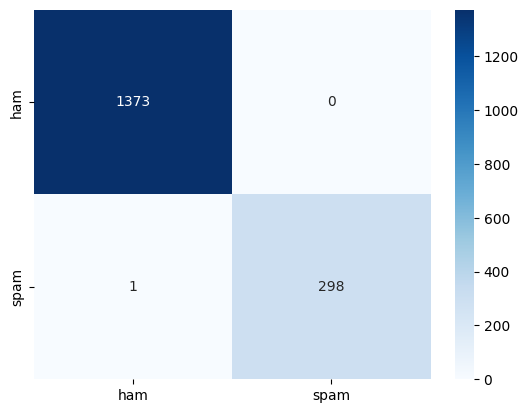

In [30]:
#Подивимось на матрицю помилок
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

In [31]:
#збережемо нашу модель
import joblib
joblib.dump(model, 'random_forest_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [33]:
# Завантажимо нашу модель
clf_loaded = joblib.load('random_forest_model.pkl') # Завантажимо нашу модель
tfidf_loaded = joblib.load('tfidf_vectorizer.pkl') #завантажимо збережений TfidfVectorizer, який перетворює текст на числову форму (TF-IDF)
label_encoder = joblib.load('label_encoder.pkl') #Завантажимо LabelEncoder, який перетворює мітки класів spam і ham у числа

In [35]:
# Список повідомлень для тестування
messages = [
    #spam
    "Congratulations! You've won a $1000 prize. Claim it now!",
    "Exclusive offer: Get a free iPhone when you sign up today!",
    "Your account has been compromised. Click here to verify immediately.",
    "Limited-time offer! Save 50% on all products. Act fast!",
    "You have an unclaimed gift card. Click here to redeem it!",
    "Urgent: You’ve been selected for a free vacation package.",
    "Get a free quote for life insurance today!",
    "Hurry! Last chance to win a luxury cruise for two.",
    "Congratulations! You've been selected to receive a $1000 gift card to your favorite store. To claim your prize, simply click the link below and enter your details. This offer is valid for a limited time only, so act quickly to take advantage of this amazing opportunity!",
    "Hurry up! For the next 24 hours, we're offering an exclusive buy-one-get-one-free deal on all products in our online store. Don’t miss out on this limited-time promotion. Visit our website now to shop and get double the value for your money!",

    #no spam
    "Hi Alex, I saw your request for a copy of the presentation from last week's seminar. I’ve attached it to this email for your reference. Let me know if you need any additional information or have other questions.",
    "Dear Mrs. Thompson, I hope this message finds you well. I wanted to confirm our appointment scheduled for next Tuesday at 10 AM. If you need to reschedule or have any questions, please let me know. Sincerely, Dr. Smith",
    "Hello team, please find attached the updated report for Q3. We need to review the figures and finalize them before our next strategy meeting. Let's aim to have all feedback by end of day tomorrow. Thanks!",
    "Hi Sarah, just wanted to check in and see how your new project is going. Let me know if you need any help or if there's anything specific we should discuss in our next meeting. Best regards, John",
    "Hey, do you want to grab lunch tomorrow?",
    "Please review the document I sent you and provide feedback.",
    "Are you coming to the team meeting this afternoon?",
    "Let’s meet at 6 PM at the coffee shop.",
    "I’ve attached the presentation for the client. Let me know your thoughts.",
    "Don’t forget about the dentist appointment next Tuesday.",
    "Can you send me the details for the project?",
    "Looking forward to our meeting on Friday."
]

# Очікувані мітки (використовуємо 'spam' для спаму та 'ham' для не спаму)
true_labels = ['spam','spam','spam','spam', 'spam','spam','spam','spam','spam','spam',
               'ham','ham', 'ham','ham','ham','ham','ham','ham','ham','ham','ham','ham']

# Цикл з кожного повідомлення
for i, message in enumerate(messages):
    # Попередня обробка тексту
    message_clean = preprocess_text(message)
    
    # Перетворюємо текст за допомогою TfidfVectorizer
    message_tfidf = tfidf_loaded.transform([message_clean])
    
    # Перетворимо на DataFrame з TF-IDF ознаками
    message_df = pd.DataFrame(message_tfidf.toarray(), columns=tfidf_loaded.get_feature_names_out())
    
    # Створення ознак для нового тексту
    message_features = create_features(most_common_words, pd.DataFrame({'clean_data': [message_clean]}))
    
    # Видалення колонки 'clean_data'
    message_features_df = message_features.drop(columns=['clean_data'])

    # Об'єднання двох DataFrame по стовбчикам
    combined_df = pd.concat([message_features_df, message_df], axis=1)
    # Пророцтво
    prediction = clf_loaded.predict(combined_df)
    predicted_category = label_encoder.inverse_transform(prediction)
    
    # Перевіряємо результат: порівнюємо передбачену мітку з істинною міткою
    result = '+' if (true_labels[i] == predicted_category[0]) else '-'
    
    print(f'Message {i+1}: {message[:50]}... Prediction: {predicted_category[0]}, True: {true_labels[i]}, Result: {result}')

Message 1: Congratulations! You've won a $1000 prize. Claim i... Prediction: spam, True: spam, Result: +
Message 2: Exclusive offer: Get a free iPhone when you sign u... Prediction: spam, True: spam, Result: +
Message 3: Your account has been compromised. Click here to v... Prediction: spam, True: spam, Result: +
Message 4: Limited-time offer! Save 50% on all products. Act ... Prediction: spam, True: spam, Result: +
Message 5: You have an unclaimed gift card. Click here to red... Prediction: spam, True: spam, Result: +
Message 6: Urgent: You’ve been selected for a free vacation p... Prediction: spam, True: spam, Result: +
Message 7: Get a free quote for life insurance today!... Prediction: spam, True: spam, Result: +
Message 8: Hurry! Last chance to win a luxury cruise for two.... Prediction: spam, True: spam, Result: +
Message 9: Congratulations! You've been selected to receive a... Prediction: spam, True: spam, Result: +
Message 10: Hurry up! For the next 24 hours, we're offering an.